Data Date Range:
    <br />Start time: 2016-05-05 09:40:26
    <br />End time: 2018-01-17 01:59:42

#### This notebook generates the following table:
- trailers_played_info: properties of all trailers played
- trailers_played_info_count: properties of all trailers played, and the number of time each is played

#### This notebook explores:  
How often do users rate/wishlist a movie after they've watched the trailer? (No related files are generated)

### Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
total_played = pd.read_csv("../Clean_Data/total_played_alg.csv")
total_played.count()

userId           166959
loginId          166959
movieId          166959
action           166959
tstamp           166959
position         166959
sessionIds       166959
recommenderId    166959
dtype: int64

In [4]:
rec_played_alg = pd.read_csv("../Clean_Data/rec_played_alg.csv")
rec_played_alg.drop("Unnamed: 0",axis=1,inplace=True)

#### Get actions of wishlisting and rating a movie (during the trailer rec experiment)

Fetch data between the date range: '2018-01-17 01:59:42' to '2016-05-05 00:00:01'
Only the action of adding movies to wishlist

TODO: Get movie ID!!!

In [5]:
# 2.23.2018 Update: removed grouplens researchers

# Connect to the database
import pymysql.cursors
import json
import re

# We will use these lists to generate a table later. 


# Connect to the database
movieIds = []
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        
        sql = """
        SELECT * FROM log_action
        WHERE (action LIKE '%list%' OR action LIKE '%rating%') AND tstamp < '2018-01-17 01:59:42' AND tstamp > '2016-05-05 00:00:01' AND logJson LIKE '%ADD%'
        """
        cursor.execute(sql)
        for row in cursor:
            logjson = json.loads(row[4])
#             print(logjson)

            movieId =  logjson["movieId"]
#             print(movieId)
            movieIds.append(movieId)
            
        cursor.execute(sql)    
        result = cursor.fetchall()
            
finally: 
    connection.close()


In [6]:
trailer_rate_wishlist = pd.DataFrame(list(result), columns=['id','userId','loginId','action','logJson','tstamp'])

In [7]:
trailer_rate_wishlist['movieId']=movieIds

In [8]:
### Users might change their ratings. That's still an action.

In [9]:
trailer_rate_wishlist.count()

id         4555299
userId     4555299
loginId    4555299
action     4555299
logJson    4555299
tstamp     4555299
movieId    4555299
dtype: int64

#### Get actions of wishlisting movie and rating movie in the trialer model

In [10]:
%run '1 - Generate Aggregate Table with Counts Played for Algorithm.ipynb'

In [11]:
# total_played.drop("Unnamed: 0",axis=1,inplace=True)

In [12]:
action_data.drop("Unnamed: 0",axis=1,inplace=True)

In [13]:
interactions = action_data[action_data['action'].isin(["RatedMovie", "WishlistedMovie"])]

In [14]:
### Merge the table with all trailers played with user interactions in the trailer model

In [15]:
trailers_played_interactions = pd.merge(interactions, total_played, on=['userId','movieId'], how='left')
trailers_played_interactions.drop('Unnamed: 0', axis=1, inplace=True)

ValueError: labels ['Unnamed: 0'] not contained in axis

In [ ]:
trailers_played_interactions.dropna(inplace=True)

In [ ]:
trailers_played_interactions['watch_first']=False
trailers_played_interactions['respond_in_session']=False

In [ ]:
fmt = '%Y-%m-%d %H:%M:%S'


for index, row in trailers_played_interactions.iterrows():
    time_watch = row['tstamp_y']
    time_action = row['tstamp_x']
#     print(time_watch)
#     print(time_action)
    if (time_watch == 'nan' or time_action == 'nan'):
        trailers_played_interactions.loc[index, 'watch_first']=None
        print('nan!!')
        continue
    
    elif (datetime.strptime(time_watch, fmt) < datetime.strptime(time_action, fmt)):
        trailers_played_interactions.loc[index, 'watch_first']=True
        if (row['loginId_x'] == row['loginId_y']):
            trailers_played_interactions.loc[index, 'respond_in_session']=True

In [ ]:
trailers_played_interactions.head()

In [ ]:
trailers_played_info = pd.read_csv('../Clean_Data/trailers_played_info.csv')

In [65]:
trailers_played_info.count()

movieId               181977
avgRating             181977
popularityLastYear    181977
age_month             181977
count                 181977
dtype: int64

In [74]:
trailers_played_info.drop_duplicates(subset=['movieId'],inplace=True)

In [75]:
trailers_played_info = trailers_played_info[['movieId','avgRating','popularityLastYear','age_month','count']]


movieId               18596
avgRating             18596
popularityLastYear    18596
age_month             18596
count                 18596
dtype: int64

In [ ]:
# Number of unique trailers played
trailers_played_info.count()

In [76]:
trailers_played_list_rate_info = pd.merge(trailers_played_interactions, trailers_played_info, on=['movieId'], how='left')

In [153]:
### If same userId, movieId, action_x, then it's a duplicate row
trailers_played_interactions_info.drop_duplicates(['userId','movieId','action_x'], inplace=True)

In [154]:
trailers_played_interactions_info.dropna(inplace=True)

In [ ]:
trailers_played_interactions_info.head(20)

In [156]:
trailers_played_wishlist = trailers_played_interactions_info[trailers_played_interactions_info['action_x']=='WishlistedMovie']
trailers_played_rate = trailers_played_interactions_info[trailers_played_interactions_info['action_x']=='RatedMovie']

In [160]:
trailers_played_wishlist.groupby(["watch_first","respond_in_session"]).count()

userId  loginId_x  movieId  action_x  \
watch_first respond_in_session                                         
False       False                   96         96       96        96   
True        False                   97         97       97        97   
            True                  2497       2497     2497      2497   

                                tstamp_x  loginId_y  action_y  tstamp_y  \
watch_first respond_in_session                                            
False       False                     96         96        96        96   
True        False                     97         97        97        97   
            True                    2497       2497      2497      2497   

                                avgRating  popularityLastYear  age_month  \
watch_first respond_in_session                                             
False       False                      96                  96         96   
True        False                      97                  97         97   
            True                     2497                2497       2497   

                                count  
watch_first respond_in_session         
False       False                  96  
True        False                  97  
            True                 2497

In [162]:
### Percent of times when users wishlist the movie in a future session
97/(97+2497)

0.037393986121819586

In [163]:
### Percent of times when users have wishlisted the movie before watching the trailer
96/(2594+96)

0.035687732342007436

In [161]:
trailers_played_rate.groupby(["watch_first","respond_in_session"]).count()

userId  loginId_x  movieId  action_x  \
watch_first respond_in_session                                         
False       False                   35         35       35        35   
True        False                   51         51       51        51   
            True                   317        317      317       317   

                                tstamp_x  loginId_y  action_y  tstamp_y  \
watch_first respond_in_session                                            
False       False                     35         35        35        35   
True        False                     51         51        51        51   
            True                     317        317       317       317   

                                avgRating  popularityLastYear  age_month  \
watch_first respond_in_session                                             
False       False                      35                  35         35   
True        False                      51                  51         51   
            True                      317                 317        317   

                                count  
watch_first respond_in_session         
False       False                  35  
True        False                  51  
            True                  317

In [167]:
### Percent of times when users rate the movie in a future session
51/(51+317)

0.13858695652173914

In [166]:
### Percent of times when users have rated the movie before watching the trailer

35/(35+368)

0.08684863523573201

It's very interesting that many users wishlist the movie in the same session after watching the trailer!!!

It's also interesting that many users rate a movie in the same session, suggesting they've probably watched the movie!

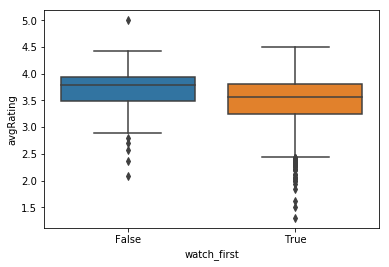

In [131]:
sns.boxplot(x='watch_first', y='avgRating', data= trailers_played_wishlist)

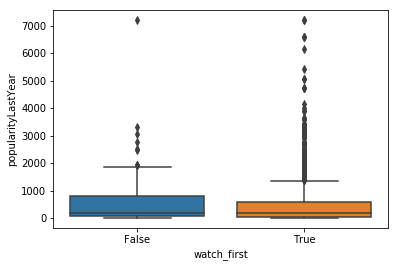

In [132]:
sns.boxplot(x='watch_first', y='popularityLastYear', data= trailers_played_wishlist)

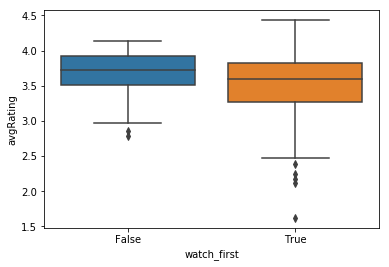

In [136]:
sns.boxplot(x='watch_first', y='avgRating', data= trailers_played_rate)

Viewers are more likely to watch the trailer of a movie they've wishlisted/rated if the corresponding has a high avgRating/is more popular.

#### Finish processing user interactions with trailers in the modal  ⤴️

#### Merge the table of all trailers played with all actions of rating and wishlisting movies. Find if users watch first or after ⬇️

In [108]:
trailers_played_list_rate = pd.merge(total_played, trailer_rate_wishlist, on=['userId','movieId'], how='left')


In [109]:
# If we don't drop NA values, then we are also examining how many times users watched a trailer but didn't do anything
# trailers_played_list_rate.dropna(inplace=True)

trailers_played_list_rate.count()

Unnamed: 0            220434
userId                220434
loginId_x             220434
movieId               220434
action_x              220434
tstamp_x              220434
id                    112424
loginId_y             112424
action_y              112424
logJson               112424
tstamp_y              112424
watch_first           112424
respond_in_session    112424
dtype: int64

In [110]:
trailers_played_list_rate.head()

,Unnamed: 0,userId,loginId_x,movieId,action_x,tstamp_x,id,loginId_y,action_y,logJson,tstamp_y,watch_first,respond_in_session
0,1,206537,trHzqo0,148482,PlayedFromLaunch,2016-05-05 16:07:54,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,4,285205,amb977W,66156,PlayedFromLaunch,2016-05-05 16:10:27,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,8,283320,5NUxm3d,4612,PlayedFromLaunch,2016-05-05 16:54:49,8940249.0,5NUxm3d,rating,"{""movieId"":4612,""rating"":3.0,""action"":""ADD"",""p...",2016-05-05 16:54:44,False,False
3,10,271845,28lSfpJ,60684,PlayedFromLaunch,2016-05-05 16:54:55,NaN,NaN,NaN,NaN,NaT,NaN,NaN
4,14,271845,28lSfpJ,4448,PlayedFromLaunch,2016-05-05 17:00:37,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [124]:
trailers_played_list_rate['watch_first']=-1
trailers_played_list_rate['respond_in_session']=-1

In [160]:
# trailers_played_list_rate['tstamp_y'].isnull()

pd.isnull(trailers_played_list_rate['tstamp_y'][1])

True

In [161]:
# This block takes a few minutes
from datetime import datetime

fmt = '%Y-%m-%d %H:%M:%S'


for index, row in trailers_played_list_rate.iterrows():
    time_action = row['tstamp_y']
    time_watch = row['tstamp_x']

    if (pd.isnull(time_action)):
        # This trailer is not both watched and rated/wishlisted
        trailers_played_list_rate.loc[index, 'watch_first']=-1

        continue
    
    elif (datetime.strptime(time_watch, fmt) < time_action.to_pydatetime()):
        # This trailer is watched before rated/wishlisted
        trailers_played_list_rate.loc[index, 'watch_first']=1
        if (row['loginId_x'] == row['loginId_y']):
            trailers_played_list_rate.loc[index, 'respond_in_session']=1
        else:
            # This trailer is rated/wishlisted before watched 
            trailers_played_list_rate.loc[index, 'respond_in_session']=0
            
    elif (datetime.strptime(time_watch, fmt) >= time_action.to_pydatetime()):
        # Watched after they've rated/wishlisted the movie
        trailers_played_list_rate.loc[index, 'watch_first']=0

In [162]:
trailers_played_list_rate.head()

,Unnamed: 0,userId,loginId_x,movieId,action_x,tstamp_x,id,loginId_y,action_y,logJson,tstamp_y,watch_first,respond_in_session
0,1,206537,trHzqo0,148482,PlayedFromLaunch,2016-05-05 16:07:54,NaN,NaN,NaN,NaN,NaT,-1,-1
1,4,285205,amb977W,66156,PlayedFromLaunch,2016-05-05 16:10:27,NaN,NaN,NaN,NaN,NaT,-1,-1
2,8,283320,5NUxm3d,4612,PlayedFromLaunch,2016-05-05 16:54:49,8940249.0,5NUxm3d,rating,"{""movieId"":4612,""rating"":3.0,""action"":""ADD"",""p...",2016-05-05 16:54:44,0,-1
3,10,271845,28lSfpJ,60684,PlayedFromLaunch,2016-05-05 16:54:55,NaN,NaN,NaN,NaN,NaT,-1,-1
4,14,271845,28lSfpJ,4448,PlayedFromLaunch,2016-05-05 17:00:37,NaN,NaN,NaN,NaN,NaT,-1,-1


In [190]:
trailers_played_list_rate.groupby(["watch_first","respond_in_session"]).count()

Unnamed: 0  userId  loginId_x  movieId  \
watch_first respond_in_session                                           
-1          -1                      108010  108010     108010   108010   
 0          -1                       32223   32223      32223    32223   
 1           0                       35792   35792      35792    35792   
             1                       44409   44409      44409    44409   

                                action_x  tstamp_x     id  loginId_y  \
watch_first respond_in_session                                         
-1          -1                    108010    108010      0          0   
 0          -1                     32223     32223  32223      32223   
 1           0                     35792     35792  35792      35792   
             1                     44409     44409  44409      44409   

                                action_y  logJson  tstamp_y  
watch_first respond_in_session                               
-1          -1                         0        0         0  
 0          -1                     32223    32223     32223  
 1           0                     35792    35792     35792  
             1                     44409    44409     44409

In [169]:
trailers_played_info = pd.read_csv('../Clean_Data/trailers_played_info.csv')

In [170]:
trailers_played_info.count()

Unnamed: 0            181977
userId                181977
loginId               181977
movieId               181977
action                181977
avgRating             181977
popularityLastYear    181977
age_month             181977
count                 181977
dtype: int64

In [173]:
trailers_played_info.drop_duplicates(subset=['movieId'],inplace=True)

In [174]:
trailers_played_info = trailers_played_info[['movieId','avgRating','popularityLastYear','age_month','count']]


In [175]:
# Number of unique trailers played
trailers_played_info.count()

movieId               18596
avgRating             18596
popularityLastYear    18596
age_month             18596
count                 18596
dtype: int64

In [184]:
trailers_played_list_rate_info = pd.merge(trailers_played_list_rate, trailers_played_info, on=['movieId'], how='left')

In [185]:
trailers_played_list_rate_info.head()

,Unnamed: 0,userId,loginId_x,movieId,action_x,tstamp_x,id,loginId_y,action_y,logJson,tstamp_y,watch_first,respond_in_session,avgRating,popularityLastYear,age_month,count
0,1,206537,trHzqo0,148482,PlayedFromLaunch,2016-05-05 16:07:54,NaN,NaN,NaN,NaN,NaT,-1,-1,3.42,15.0,16.83,8.0
1,4,285205,amb977W,66156,PlayedFromLaunch,2016-05-05 16:10:27,NaN,NaN,NaN,NaN,NaT,-1,-1,3.31,4.0,252.25,3.0
2,8,283320,5NUxm3d,4612,PlayedFromLaunch,2016-05-05 16:54:49,8940249.0,5NUxm3d,rating,"{""movieId"":4612,""rating"":3.0,""action"":""ADD"",""p...",2016-05-05 16:54:44,0,-1,3.78,5.0,789.75,2.0
3,10,271845,28lSfpJ,60684,PlayedFromLaunch,2016-05-05 16:54:55,NaN,NaN,NaN,NaN,NaT,-1,-1,3.71,1738.0,218.08,134.0
4,14,271845,28lSfpJ,4448,PlayedFromLaunch,2016-05-05 17:00:37,NaN,NaN,NaN,NaN,NaT,-1,-1,3.47,200.0,450.83,69.0


In [165]:
### If same userId, movieId, action_x, then it's a duplicate row
# trailers_played_list_rate_info.drop_duplicates(['userId','movieId','action_x'], inplace=True)

In [78]:
trailers_played_list_rate_info.dropna(inplace=True)

In [186]:
trailers_played_list_rate_info.count()

Unnamed: 0            220434
userId                220434
loginId_x             220434
movieId               220434
action_x              220434
tstamp_x              220434
id                    112424
loginId_y             112424
action_y              112424
logJson               112424
tstamp_y              112424
watch_first           220434
respond_in_session    220434
avgRating             214918
popularityLastYear    214918
age_month             214918
count                 214918
dtype: int64

In [187]:
trailers_played_wishlist = trailers_played_list_rate_info[trailers_played_list_rate_info['action_y']=='user-list']
trailers_played_rate = trailers_played_list_rate_info[trailers_played_list_rate_info['action_y']=='rating']

In [188]:
trailers_played_wishlist.groupby(["watch_first","respond_in_session"]).count()

Unnamed: 0  userId  loginId_x  movieId  \
watch_first respond_in_session                                           
0           -1                       17691   17691      17691    17691   
1            0                        4566    4566       4566     4566   
             1                       18995   18995      18995    18995   

                                action_x  tstamp_x     id  loginId_y  \
watch_first respond_in_session                                         
0           -1                     17691     17691  17691      17691   
1            0                      4566      4566   4566       4566   
             1                     18995     18995  18995      18995   

                                action_y  logJson  tstamp_y  avgRating  \
watch_first respond_in_session                                           
0           -1                     17691    17691     17691      17312   
1            0                      4566     4566      4566       4458   
             1                     18995    18995     18995      18582   

                                popularityLastYear  age_month  count  
watch_first respond_in_session                                        
0           -1                               17312      17312  17312  
1            0                                4458       4458   4458  
             1                               18582      18582  18582

In [85]:
### Percent of times when users wishlist the movie in a future session
4458/(18582+4458+17312)

0.11047779540047581

In [86]:
### Percent of times when users have wishlisted the movie before watching the trailer
17312/(18582+4458+17312)

0.4290245836637589

In [87]:
trailers_played_rate.groupby(["watch_first","respond_in_session"]).count()

id  userId  loginId_x  action_x  logJson  \
watch_first respond_in_session                                                
False       False               14198   14198      14198     14198    14198   
True        False               30551   30551      30551     30551    30551   
            True                24788   24788      24788     24788    24788   

                                tstamp_x  movieId  Unnamed: 0  loginId_y  \
watch_first respond_in_session                                             
False       False                  14198    14198       14198      14198   
True        False                  30551    30551       30551      30551   
            True                   24788    24788       24788      24788   

                                action_y  tstamp_y  avgRating  \
watch_first respond_in_session                                  
False       False                  14198     14198      14198   
True        False                  30551     30551      30551   
            True                   24788     24788      24788   

                                popularityLastYear  age_month  count  
watch_first respond_in_session                                        
False       False                            14198      14198  14198  
True        False                            30551      30551  30551  
            True                             24788      24788  24788

In [90]:
### Percent of times when users rate the movie in a future session
30551/(30551+24788+14198)

0.4393488358715504

In [89]:
### Percent of times when users have rated the movie before watching the trailer

14198/(30551+24788+14198)

0.20417907013532363

It's very interesting that many users wishlist the movie in the same session after watching the trailer!!!

It's also interesting that a lot of users do come back and rate the movie :)

### Find out actions (both on and off modal) for recs

In [11]:
# 2.23.2018 Update: removed grouplens researchers

# Connect to the database
import pymysql.cursors
import json
import re

# We will use these lists to generate a table later. 


# Connect to the database
movieIds = []
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        
        sql = """
        SELECT * FROM log_action
        WHERE (action LIKE '%list%' OR action LIKE '%rating%') AND tstamp < '2018-01-17 01:59:42' AND tstamp > '2016-05-05 00:00:01' AND logJson LIKE '%ADD%'
        """
        cursor.execute(sql)
        for row in cursor:
            logjson = json.loads(row[4])
#             print(logjson)

            movieId =  logjson["movieId"]
#             print(movieId)
            movieIds.append(movieId)
            
        cursor.execute(sql)    
        result = cursor.fetchall()
            
finally: 
    connection.close()


In [30]:
trailer_rate_wishlist = pd.DataFrame(list(result), columns=['id','userId','loginId','action','logJson','tstamp'])

In [31]:
trailer_rate_wishlist['movieId']=movieIds

In [54]:
rec_played_alg.count()

Unnamed: 0       10101
userId           10101
loginId          10101
movieId          10101
action           10101
tstamp           10101
position         10101
recommenderId     9142
dtype: int64

In [61]:
recs_played_list_rate = pd.merge(rec_played_alg, trailer_rate_wishlist, on=['userId','movieId'], how='left')


In [62]:
# Question: why is the count > 9142???

recs_played_list_rate.count()

Unnamed: 0       10901
userId           10901
loginId_x        10901
movieId          10901
action_x         10901
tstamp_x         10901
position         10901
recommenderId     9878
id                3324
loginId_y         3324
action_y          3324
logJson           3324
tstamp_y          3324
dtype: int64

In [63]:
recs_played_list_rate['watch_first']=-1
recs_played_list_rate['respond_in_session']=-1

In [44]:
# This block takes a few minutes
from datetime import datetime

fmt = '%Y-%m-%d %H:%M:%S'


for index, row in recs_played_list_rate.iterrows():
    time_action = row['tstamp_y']
    time_watch = row['tstamp_x']

    if (pd.isnull(time_action)):
        # This trailer is not both watched and rated/wishlisted
        recs_played_list_rate.loc[index, 'watch_first']=-1
        recs_played_list_rate.loc[index, 'respond_in_session']=-1

        continue
    
    elif (datetime.strptime(time_watch, fmt) < time_action.to_pydatetime()):
        # This trailer is watched before rated/wishlisted
        recs_played_list_rate.loc[index, 'watch_first']=1
        if (row['loginId_x'] == row['loginId_y']):
            recs_played_list_rate.loc[index, 'respond_in_session']=1
        else:
            # This trailer is rated/wishlisted before watched 
            recs_played_list_rate.loc[index, 'respond_in_session']=0
            
    elif (datetime.strptime(time_watch, fmt) >= time_action.to_pydatetime()):
        # Watched after they've rated/wishlisted the movie
        recs_played_list_rate.loc[index, 'watch_first']=0

In [47]:
# Check Accuracy here!!!

recs_played_list_rate.groupby(["watch_first","respond_in_session","action_y"]).count()

Unnamed: 0  userId  loginId_x  \
watch_first respond_in_session action_y                                    
1.0         0.0                rating             741     741        741   
                               tag-rating           2       2          2   
                               user-list          137     137        137   
            1.0                rating             406     406        406   
                               user-list          779     779        779   

                                           movieId  action_x  tstamp_x  \
watch_first respond_in_session action_y                                  
1.0         0.0                rating          741       741       741   
                               tag-rating        2         2         2   
                               user-list       137       137       137   
            1.0                rating          406       406       406   
                               user-list       779       779       779   

                                           position  recommenderId   id  \
watch_first respond_in_session action_y                                   
1.0         0.0                rating           741            656  741   
                               tag-rating         2              2    2   
                               user-list        137            121  137   
            1.0                rating           406            376  406   
                               user-list        779            699  779   

                                           loginId_y  logJson  tstamp_y  
watch_first respond_in_session action_y                                  
1.0         0.0                rating            741      741       741  
                               tag-rating          2        2         2  
                               user-list         137      137       137  
            1.0                rating            406      406       406  
                               user-list         779      779       779

In [48]:
recs_played_wishlist = recs_played_list_rate[recs_played_list_rate['action_y']=='user-list']
recs_played_rate = recs_played_list_rate[recs_played_list_rate['action_y']=='rating']

In [49]:
recs_played_wishlist.groupby(["watch_first","respond_in_session"]).count()

Unnamed: 0  userId  loginId_x  movieId  \
watch_first respond_in_session                                           
1.0         0.0                        137     137        137      137   
            1.0                        779     779        779      779   

                                action_x  tstamp_x  position  recommenderId  \
watch_first respond_in_session                                                
1.0         0.0                      137       137       137            121   
            1.0                      779       779       779            699   

                                 id  loginId_y  action_y  logJson  tstamp_y  
watch_first respond_in_session                                               
1.0         0.0                 137        137       137      137       137  
            1.0                 779        779       779      779       779

In [50]:
recs_played_rate.groupby(["watch_first","respond_in_session"]).count()

Unnamed: 0  userId  loginId_x  movieId  \
watch_first respond_in_session                                           
1.0         0.0                        741     741        741      741   
            1.0                        406     406        406      406   

                                action_x  tstamp_x  position  recommenderId  \
watch_first respond_in_session                                                
1.0         0.0                      741       741       741            656   
            1.0                      406       406       406            376   

                                 id  loginId_y  action_y  logJson  tstamp_y  
watch_first respond_in_session                                               
1.0         0.0                 741        741       741      741       741  
            1.0                 406        406       406      406       406

### Find out the popularities, avgRatings, age of all trailers played

In [8]:
trailers_played = pd.read_csv("../Clean_Data/total_played_alg.csv")

In [8]:
# Append the information about movie popularity to the table we just crated

trailers_played['avgRating'] = avgRating_list_all_trailers
trailers_played['popularityLastYear'] = popularity_list_all_trailers
trailers_played['release_date'] = release_date_all_trailers


,Unnamed: 0,userId,loginId,movieId,action,tstamp,avgRating,popularityLastYear,release_date
0,1,206537,trHzqo0,148482,PlayedFromLaunch,2016-05-05 16:07:54,3.42466,15.0,2015-10-16
1,4,285205,amb977W,66156,PlayedFromLaunch,2016-05-05 16:10:27,3.30769,4.0,2008-01-21
2,8,283320,5NUxm3d,4612,PlayedFromLaunch,2016-05-05 16:54:49,3.78297,5.0,1990-05-25
3,10,271845,28lSfpJ,60684,PlayedFromLaunch,2016-05-05 16:54:55,3.70795,1738.0,2009-03-06
4,14,271845,28lSfpJ,4448,PlayedFromLaunch,2016-05-05 17:00:37,3.46621,200.0,2001-07-13
5,17,271845,28lSfpJ,1234,PlayedFromNext,2016-05-05 17:01:30,4.14385,512.0,1973-12-25
6,20,285565,ElIYhrB,152081,PlayedFromLaunch,2016-05-05 17:02:17,3.94208,2560.0,2016-02-12
7,23,176653,YFDaccp,2959,PlayedFromLaunch,2016-05-05 17:04:55,4.23027,6154.0,1999-10-15
8,25,285565,ElIYhrB,2762,PlayedFromLaunch,2016-05-05 17:06:24,4.01764,3011.0,1999-08-06
9,37,285565,ElIYhrB,1198,PlayedFromLaunch,2016-05-05 17:08:44,4.12602,3922.0,1981-06-12


In [9]:
trailers_played.drop("Unnamed: 0",axis=1,inplace=True)
trailers_played.head()


,userId,loginId,movieId,action,tstamp,avgRating,popularityLastYear,release_date
0,206537,trHzqo0,148482,PlayedFromLaunch,2016-05-05 16:07:54,3.42466,15.0,2015-10-16
1,285205,amb977W,66156,PlayedFromLaunch,2016-05-05 16:10:27,3.30769,4.0,2008-01-21
2,283320,5NUxm3d,4612,PlayedFromLaunch,2016-05-05 16:54:49,3.78297,5.0,1990-05-25
3,271845,28lSfpJ,60684,PlayedFromLaunch,2016-05-05 16:54:55,3.70795,1738.0,2009-03-06
4,271845,28lSfpJ,4448,PlayedFromLaunch,2016-05-05 17:00:37,3.46621,200.0,2001-07-13


In [12]:
trailers_played.dtypes

userId                  int64
loginId                object
movieId                 int64
action                 object
tstamp                 object
avgRating             float64
popularityLastYear    float64
release_date           object
dtype: object

In [15]:
# This section finds out the age of each movie when its trailer is played

# This part takes a few minutes...
# TODO: Find a faster way to process the information

from datetime import datetime

# Find the age of each movie when it's played
ageAtViewDate = []

fmt = '%Y-%m-%d %H:%M:%S'

for index, row in trailers_played.iterrows():
    
#     time1 = row[4].datetime.date()
#     time2 = row[7]

    time1 = datetime.strptime(row[4], fmt).date()
    time2 = row[7]

    # Be careful with bad data
    if (time1 == '0000-00-00' or time2 == '0000-00-00'):
        ageAtViewDate.append(None)
        continue
    elif (time1 == None or time2 == None):
        ageAtViewDate.append(None)
        continue
    
    else:
        this_age = time1-time2
        ageAtViewDate.append(this_age)


In [16]:
trailers_played['age'] = ageAtViewDate

In [18]:
trailers_played['ageMonth'] = trailers_played['age'].astype('timedelta64[D]')/12

In [23]:
trailers_played=np.round(trailers_played,decimals=2)


In [ ]:
trailers_played.dropna(inplace=True)
trailers_played.drop(["age","tstamp","release_date"],axis=1,inplace=True)

In [32]:
trailers_played.to_csv("../Clean_Data/trailers_played_info.csv")

### How many times each trailer has been played

In [16]:
# NumTrailerRecommended = pd.DataFrame({'MovieId': [a], 'Counts': [b]})
trailers_played = pd.read_csv("../Clean_Data/trailers_played_info.csv")
trailers_played.drop("Unnamed: 0",axis=1,inplace=True)
# # Add headers to columns
# movie_rec_counts.columns = ["movieId","Counts"]
# movie_rec_counts

# Sort;
# Cumulative percentage of counts;


In [17]:
trailers_played_count = trailers_played.groupby("movieId").count().reset_index()[['movieId','userId']].copy()

In [18]:
trailers_played_count.rename(index=str, columns={"userId":"count"},inplace=True)

In [19]:
trailers_played_count_agg = pd.merge(trailers_played, trailers_played_count, on=['movieId'], how='left')
trailers_played_count_agg

,userId,loginId,movieId,action,avgRating,popularityLastYear,age_month,count_x,count_y
0,206537,trHzqo0,148482,PlayedFromLaunch,3.42,15.0,16.83,8,8
1,285205,amb977W,66156,PlayedFromLaunch,3.31,4.0,252.25,3,3
2,283320,5NUxm3d,4612,PlayedFromLaunch,3.78,5.0,789.75,2,2
3,271845,28lSfpJ,60684,PlayedFromLaunch,3.71,1738.0,218.08,134,134
4,271845,28lSfpJ,4448,PlayedFromLaunch,3.47,200.0,450.83,69,69
5,271845,28lSfpJ,1234,PlayedFromNext,4.14,512.0,1289.33,49,49
6,285565,ElIYhrB,152081,PlayedFromLaunch,3.94,2560.0,6.92,104,104
7,176653,YFDaccp,2959,PlayedFromLaunch,4.23,6154.0,503.92,123,123
8,285565,ElIYhrB,2762,PlayedFromLaunch,4.02,3011.0,509.75,94,94
9,285565,ElIYhrB,1198,PlayedFromLaunch,4.13,3922.0,1062.17,66,66


In [20]:
trailers_played_count_agg.to_csv("../Clean_Data/trailers_played_info_count.csv")